# Poisson Data Loading and Visualization Tutorial

This notebook demonstrates how to load the Poisson equation data using the `SinFrequency` class from the CNOBenchmarks framework and visualize the data using matplotlib.

## Overview Option 1 (`in_size=s=64`)
- **Data**: Poisson equation with sinusoidal frequency source terms
- **Input**: Source term f(x,y) 
- **Output**: Solution u(x,y) where ∇²u = f
- **Resolution**: 64x64 grid
- **File**: `/cluster/home/lkellijs/camlab-pino/data/PoissonData_64x64_IN.h5`

## Overview Option 2 (`in_size=s=128`)
- **Data**: Poisson equation with sinusoidal frequency source terms
- **Input**: Source term f(x,y) 
- **Output**: Solution u(x,y) where ∇²u = f
- **Resolution**: 128x128 grid
- **File**: `/cluster/home/lkellijs/camlab-pino/data/Poisson_res/PoissonData_NEW_s128.h5`
- **Note**: the igher resolution dataset is likely much smaller in size

## 1. Import Libraries


In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from Problems.CNOBenchmarks import SinFrequency
import sys
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


## 2. Define Network Properties

The `SinFrequency` class requires network properties even though we're only loading data. These parameters define the CNN architecture that would be used for training.


In [6]:
# Define network architecture parameters (for CNO - just like in TrainCNO.py)
network_properties = {
    # Required parameters
    "in_size": 64,           # Input spatial resolution (128x128 or 64x64)
    "N_layers": 4,           # Number of (D) & (U) blocks 
    "N_res": 5,              # Number of (R) blocks in middle layers
    "N_res_neck": 5,         # Number of (R) blocks in bottleneck
    
    # Optional parameters (with defaults)
    "channel_multiplier": 16, # Channel expansion factor
    "kernel_size": 3,         # Convolution kernel size
    "retrain": 42,            # Random seed
    "FourierF": 0,            # Number of Fourier features (0 = none)
    "activation": 'cno_lrelu', # Activation function
    
    # Filter properties
    "cutoff_den": 2.0001,     # Cutoff parameter
    "lrelu_upsampling": 2,    # Upsampling coefficient
    "half_width_mult": 0.8,   # Half-width multiplier
    "filter_size": 6,         # Filter size
    "radial_filter": 0,       # Radial symmetry flag
}

print("Network properties defined:")
for key, value in network_properties.items():
    print(f"  {key}: {value}")


Network properties defined:
  in_size: 64
  N_layers: 4
  N_res: 5
  N_res_neck: 5
  channel_multiplier: 16
  kernel_size: 3
  retrain: 42
  FourierF: 0
  activation: cno_lrelu
  cutoff_den: 2.0001
  lrelu_upsampling: 2
  half_width_mult: 0.8
  filter_size: 6
  radial_filter: 0


## 3. Initialize the SinFrequency Class

This creates the data loaders for training, validation, and testing.


In [7]:
# Data loading parameters
batch_size = 16
training_samples = 1024  # Number of training samples to use
s = 64                   # Spatial resolution
in_dist = True          # Use in-distribution data

# Initialize the SinFrequency class
print("Initializing SinFrequency class...")
example = SinFrequency(
    network_properties=network_properties,
    device=device,
    batch_size=batch_size,
    training_samples=training_samples,
    s=s,
    in_dist=in_dist
)

print(f"✓ Data loaders created successfully!")
print(f"  - Training samples: {training_samples}")
print(f"  - Validation samples: 128")
print(f"  - Test samples: 256")
print(f"  - Batch size: {batch_size}")
print(f"  - Spatial resolution: {s}x{s}")


Initializing SinFrequency class...
in_size: 64
Domain not found in file, using default value of 1.0
Domain not found in file, using default value of 1.0
Domain not found in file, using default value of 1.0
✓ Data loaders created successfully!
  - Training samples: 1024
  - Validation samples: 128
  - Test samples: 256
  - Batch size: 16
  - Spatial resolution: 64x64


## 4. Explore the Data Loaders

Let's examine the structure of our data loaders.


In [8]:
# Access the data loaders
train_loader = example.train_loader
val_loader = example.val_loader
test_loader = example.test_loader

print("Data loader information:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Get a single batch to examine data structure
print("\nExamining data structure...")
for i, (inputs, outputs) in enumerate(train_loader):
    print(f"  Input shape: {inputs.shape}")
    print(f"  Output shape: {outputs.shape}")
    print(f"  Input data type: {inputs.dtype}")
    print(f"  Output data type: {outputs.dtype}")
    print(f"  Input range: [{inputs.min():.3f}, {inputs.max():.3f}]")
    print(f"  Output range: [{outputs.min():.3f}, {outputs.max():.3f}]")
    break  # Only examine first batch


Data loader information:
  Training batches: 64
  Validation batches: 8
  Test batches: 16

Examining data structure...
  Input shape: torch.Size([16, 1, 64, 64])
  Output shape: torch.Size([16, 1, 64, 64])
  Input data type: torch.float32
  Output data type: torch.float32
  Input range: [0.143, 0.862]
  Output range: [0.098, 0.851]


## 5. Visualize Individual Samples

Let's plot some individual samples to understand the data better.


In [9]:
cmap = 'gist_ncar'

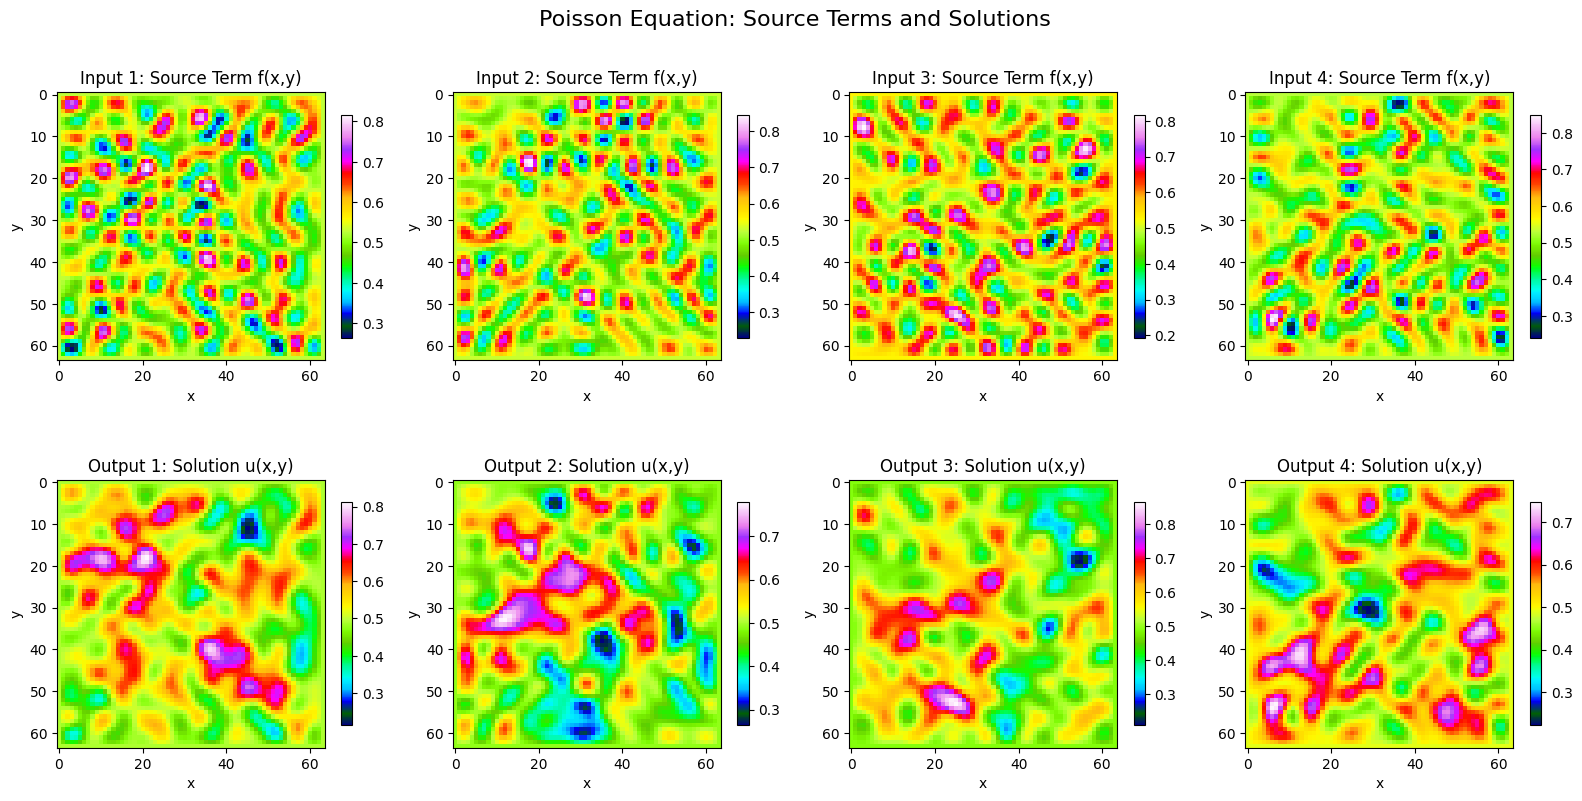

In [10]:
# Get a batch of data
inputs, outputs = next(iter(train_loader))

# Convert to numpy for plotting
inputs_np = inputs.cpu().numpy()
outputs_np = outputs.cpu().numpy()

# Plot first 4 samples from the batch
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

n_samples = min(4, inputs_np.shape[0])

for i in range(n_samples):
    # Plot input (source term)
    im1 = axes[0, i].imshow(inputs_np[i, 0], cmap=cmap, aspect='equal')
    axes[0, i].set_title(f'Input {i+1}: Source Term f(x,y)')
    axes[0, i].set_xlabel('x')
    axes[0, i].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0, i], shrink=0.6)
    
    # Plot output (solution)
    im2 = axes[1, i].imshow(outputs_np[i, 0], cmap=cmap, aspect='equal')
    axes[1, i].set_title(f'Output {i+1}: Solution u(x,y)')
    axes[1, i].set_xlabel('x')
    axes[1, i].set_ylabel('y')
    plt.colorbar(im2, ax=axes[1, i], shrink=0.6)

plt.tight_layout()
plt.suptitle('Poisson Equation: Source Terms and Solutions', fontsize=16, y=1.02)
plt.show()


## 6. Compare Different Data Splits


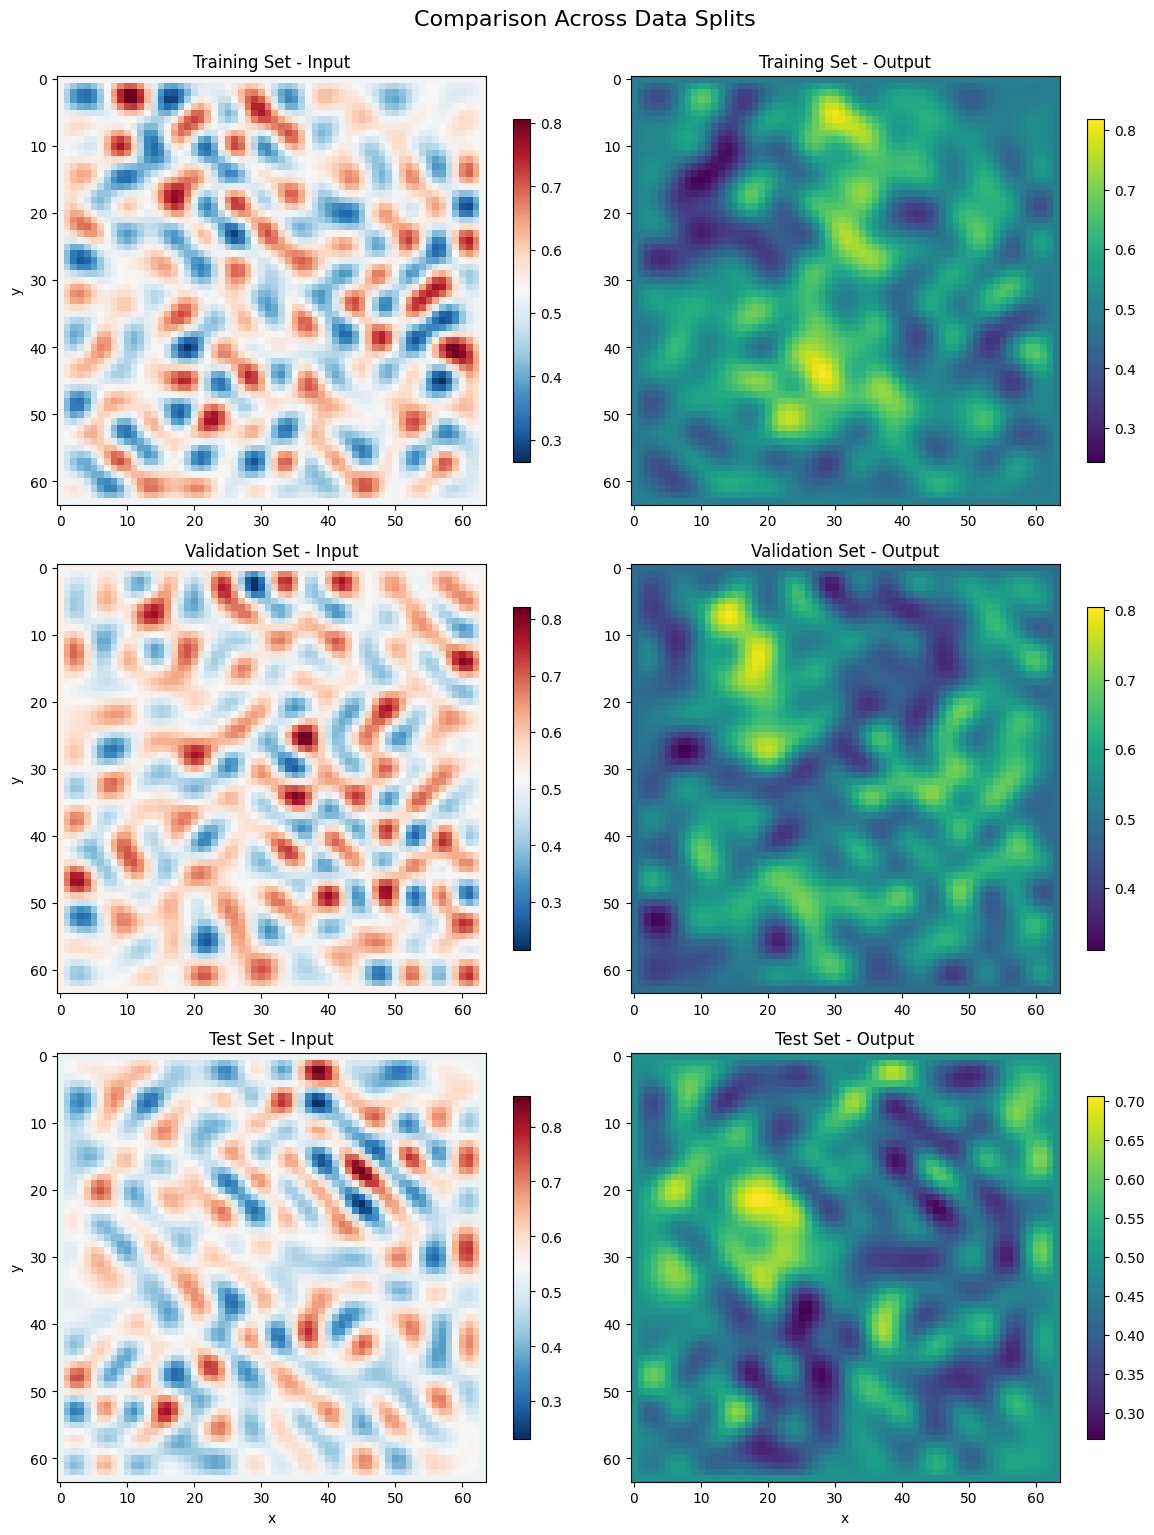

In [11]:
# Get one sample from each data split
train_inputs, train_outputs = next(iter(train_loader))
val_inputs, val_outputs = next(iter(val_loader))
test_inputs, test_outputs = next(iter(test_loader))

# Plot comparison
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

datasets = [
    (train_inputs[0], train_outputs[0], "Training"),
    (val_inputs[0], val_outputs[0], "Validation"),
    (test_inputs[0], test_outputs[0], "Test")
]

for i, (inp, out, name) in enumerate(datasets):
    # Plot input
    im1 = axes[i, 0].imshow(inp[0].cpu().numpy(), cmap='RdBu_r', aspect='equal')
    axes[i, 0].set_title(f'{name} Set - Input')
    axes[i, 0].set_ylabel('y')
    if i == 2:  # Last row
        axes[i, 0].set_xlabel('x')
    plt.colorbar(im1, ax=axes[i, 0], shrink=0.8)
    
    # Plot output
    im2 = axes[i, 1].imshow(out[0].cpu().numpy(), cmap='viridis', aspect='equal')
    axes[i, 1].set_title(f'{name} Set - Output')
    if i == 2:  # Last row
        axes[i, 1].set_xlabel('x')
    plt.colorbar(im2, ax=axes[i, 1], shrink=0.8)

plt.tight_layout()
plt.suptitle('Comparison Across Data Splits', fontsize=16, y=1.02)
plt.show()


## 8. Summary

This tutorial demonstrated:

1. **Data Loading**: How to use the `SinFrequency` class to load Poisson equation data
2. **Data Structure**: Understanding the input/output format and normalization
3. **Visualization**: Multiple ways to visualize the data (2D heatmaps)
4. **Data Iteration**: How to iterate through batches during training
5. **Data Splits**: Accessing training, validation, and test sets

### Key Points:
- Input data represents the source term f(x,y) in the Poisson equation ∇²u = f
- Output data represents the solution u(x,y)
- Data is normalized to [0,1] range for better training stability
- The framework supports different spatial resolutions and Fourier features
- All data loaders return PyTorch tensors ready for training

### Next Steps:
- Use this data loading framework with your CNN models
- Experiment with different batch sizes and data augmentation
- Try adding Fourier features by setting `FourierF > 0` in network properties
